In [14]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
#%matplotlib notebook
#import matplotlib.pylab as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()
if num_cores == 32:
    num_cores = 24  # lsst-dev - don't use all the cores, man.
elif num_cores == 8:
    num_cores = 3
elif num_cores == 4:
    num_cores = 2
print num_cores

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

pd.options.display.max_columns = 9999
pd.set_option('display.width', 9999)

import warnings
warnings.filterwarnings('ignore')

import diffimTests as dit

3


In [15]:
# Set up console so we can reattach via terminal ipython later. See:
# https://stackoverflow.com/questions/19479645/using-ipython-console-along-side-ipython-notebook

%qtconsole

# Then do `ipython console --existing` in a terminal to connect and have access to same data!
# But note, do not do CTRL-D in that terminal or it will kill the kernel!

## New topic: double gaussian psf...

1.0


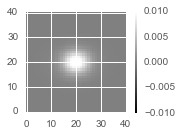

In [16]:
reload(dit)
psfSize = 21
x = np.arange(-psfSize+1, psfSize, 1)
y = x.copy()
y0, x0 = np.meshgrid(x, y)
psf = dit.doubleGaussian2d(x0, y0, 0, 0, a=0.7, sigma_x1=3.0, sigma_y1=3.5, theta1=0.,
                          sigma_x2=5.5, sigma_y2=7.5, theta2=0.)
print psf.sum()
dit.plotImageGrid((psf,), clim=(-0.01, 0.01))

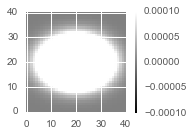

In [17]:
dit.plotImageGrid((psf,), clim=(-0.0001, 0.0001))

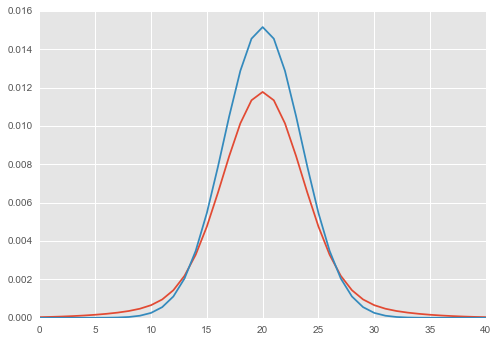

In [18]:
psf2 = dit.singleGaussian2d(x0, y0, 0, 0, sigma_x=3.0, sigma_y=3.5, theta=0.)
plt.plot(psf[20,:])
plt.plot(psf2[20,:])

## Use `galsim` for Kolmogorov PSF...

5476
galsim.BoundsI(1,74,1,74) 74


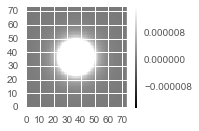

In [19]:
import galsim
gsp = galsim.GSParams(folding_threshold=1.0/512., maximum_fft_size=12288)
psf = galsim.Kolmogorov(fwhm=0.7, flux=1, gsparams=gsp)
im = psf.drawImage(method='real_space', scale=0.2)
#print psf.flux
print im.image.array.size
bounds = im.getBounds()
print bounds, bounds.getXMax()
arr = im.image.array.reshape(bounds.getXMax(), bounds.getXMax())
dit.plotImageGrid((arr,))

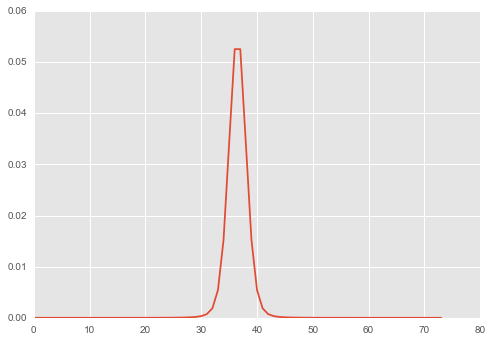

In [20]:
plt.plot(arr[bounds.getXMax()//2,:])

## Now a Moffat...

10.4150761925
1.0


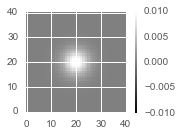

In [32]:
reload(dit)

psfSize = 21
x = np.arange(-psfSize+1, psfSize, 1)
y = x.copy()
y0, x0 = np.meshgrid(x, y)
psf = dit.moffat2d(x0, y0, 0, 0, 3.5*2.355)  # fwhm = 2.355 * sigma
print psf.sum()
dit.plotImageGrid((psf,), clim=(-0.01, 0.01))

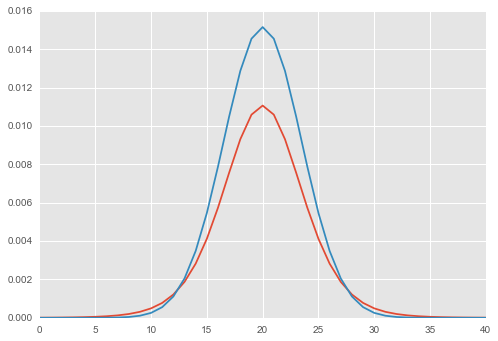

In [33]:
plt.plot(psf[20,:])
plt.plot(psf2[20,:])